# OCR Agent from scratch:

* [Data](Data-Sources.ipynb)
* [Utilities](Data-Processing.ipynb)
* [Extract layout features and visual tokens](Data-Extraction-2.ipynb)
* Generate training data
    * Labeling
    * [Pipeline](Data-Extraction-Pipeline.ipynb)
    * [Datasets](Datasets.ipynb)
* [Model architecture](Model-Backbone.ipynb)
* [Traversal strategies](Traversal-Layout.ipynb)
* [Reader Agent](Agent-LM.ipynb)
* [Leverage synthetic training data](Data-Gen.ipynb)
* [Optimization for production](Optimization.ipynb)


### Generate labeled data samples for training
We've got our initial simple segmentation and traversal set up, and we have the data extracted from pdf.
The data is word-level; for out project we need character-level boxes. The project requirements are such that we should not relay on the word recognition and the language-specific statistics. Agent should be able to read reliably random sequence of symbols.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from IPython.display import display, clear_output
from pathlib import Path
from sklearn.neighbors import KDTree
from unidecode import unidecode
from time import sleep

In [2]:
from scripts.extract import *

In [3]:
samples = [str(x)[12:-4] for x in Path('./data/images').glob('*.png')]
len(samples)

8631

In [4]:
source = np.random.choice(samples)

In [5]:
print(source)
image = load_image(source)
print(np.min(image), np.max(image))
#Image.fromarray(image)

irs-f14095-0
0 255


## Data for training
To train the model we need the tokens with reliable labels. We start from the character level.

In [6]:
tokens, words, lines, boxes, _ = extract_layout(image)

In [7]:
tokens['index'] = None

result = run_checkup(tokens, image)
len(tokens[tokens['index']!=-1]), len(tokens)

(3072, 3075)

In [8]:
tokens = tokens.loc[tokens['index']!=-1,:].drop('index', axis=1)

stats = tokens.iloc[:,:4].astype(float).describe()
stats.style.background_gradient()

,left,top,width,height
count,3072.000000,3072.000000,3072.000000,3072.000000
mean,1093.285807,1593.011068,15.189779,37.255534
std,616.103974,865.159359,6.369200,2.889837
min,149.000000,164.000000,1.000000,25.000000
25%,547.500000,764.000000,10.000000,37.000000
50%,1036.000000,1679.000000,17.000000,37.000000
75%,1577.250000,2325.000000,18.000000,37.000000
max,2392.000000,3180.000000,45.000000,58.000000


In [9]:
# estimated textline height
LN = int(stats.loc['50%','height'].round())

In [10]:
# set center-point reference for matching label
tokens['level'] = (tokens['top'] + tokens['height']//4).astype(int)
tokens['order'] = (tokens['left'] + tokens['width']//2).astype(int)
    
boxes.loc[:,['block-index','line-index','word-index']] = -1
boxes['level'] = (boxes['top'] + boxes['height']//4).astype(int)
boxes['order'] = (boxes['left'] + boxes['width']//2).astype(int)
# lift center-point for underscore-lines to match the input space
boxes.loc[boxes['type']==HLINE,'level'] -= LN//4
tokens = pd.concat([tokens, boxes[tokens.columns]]).set_index(['level','order'])

#### Normalized grid for the labels retrieval from PDF data

In [11]:
# rough relative char width estimation
def map_char_width(estimated_line_height):
    scale = cv2.getFontScaleFromHeight(cv2.FONT_HERSHEY_SIMPLEX, estimated_line_height, 1)
    (w, h), baseline = cv2.getTextSize('test', cv2.FONT_HERSHEY_SIMPLEX, scale, 1)
    print(f'Estimated fontsize: {estimated_line_height}  scale: {scale:.2f}  baseline-height: {baseline}')
    return { c:cv2.getTextSize(c, cv2.FONT_HERSHEY_SIMPLEX, scale, 1)[0][0]/estimated_line_height
             for c in list(string.printable)[:-5] } # tail dropped: \t\n\r\x0b\x0c


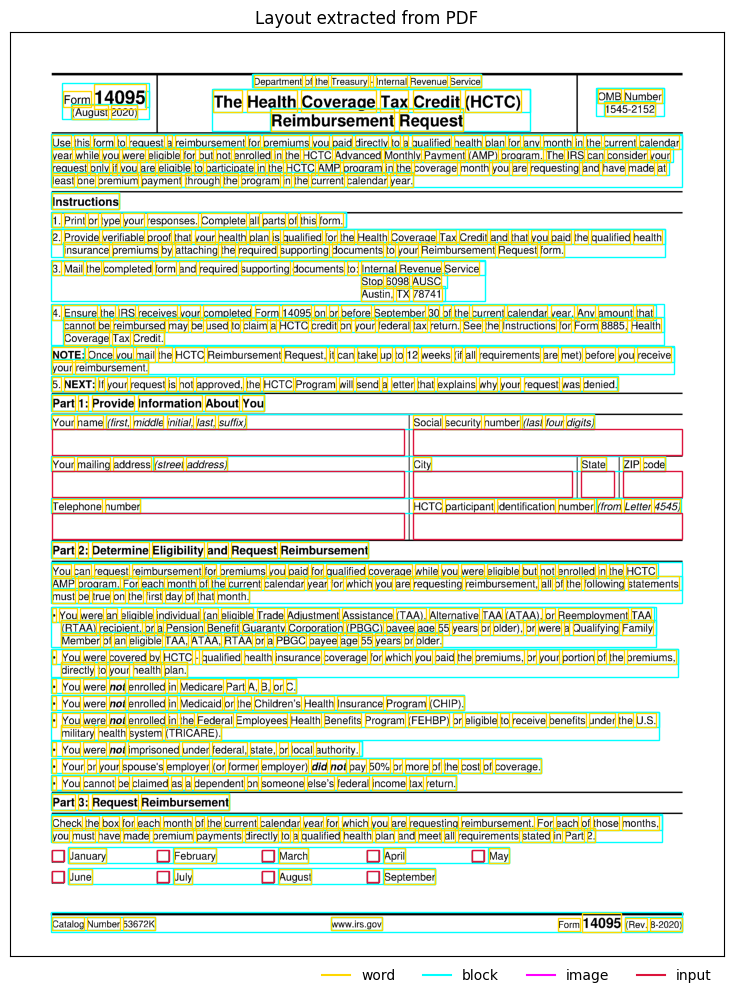

In [12]:
plot_info(source)

In [13]:
def get_words(content):
    scale = int(content.loc[0, 'scale'])
    columns = ['text','left','top','right','bottom','sin']
    words = content.loc[(content['block-type']=='word')&(~content['text'].isna()), columns]
    words['rotation'] = words['sin'].apply(lambda x:0 if np.isnan(x) else np.rad2deg(np.arcsin(1)))
    words.loc[:,['left','top','right','bottom']] = (words[['left','top','right','bottom']] * scale).round()
    return words.loc[:,['left','top','right','bottom','rotation','text']]


In [14]:
def get_chars(words, size_map):
    """
    based on generic font aspect ratio
    estimate individual characters bounding boxes
    within the given word bounding box
    """
    chars = words[BOX + ['index']].copy()
    chars['label'] = words['text'].apply(list)
    chars = chars.explode('label', ignore_index=True)
    
    def calc_width(r):
        if unidecode(r['label']) in size_map:
            return size_map[unidecode(r['label'])] * r['height']
        return r['width']
    chars['char-width'] = chars.apply(calc_width, axis=1)
    
    A = chars[['char-width','index']].groupby('index').sum()
    B = chars[['width','index']].groupby('index').mean()
    f = pd.Series((B.values/A.values).flatten(), index=A.index).rename('factor').reset_index()
    chars = chars.merge(f, on=('index'))
    chars = chars.loc[(chars['width'] > 0)&(chars['height'] > 0)]
    chars['char-width'] = (chars['char-width'] * chars['factor']).astype(int)
    
    chars = chars.loc[:,['left','top','char-width','height','label','index']]
    chars.columns = BOX + ['label','word-index']
    shift = chars.groupby('word-index')['width'].cumsum().values.tolist()
    chars['left'] += shift - chars['width']    
    chars['type'] = CHAR
    return chars


In [15]:
def load_labels(source: str, line_norm : int):
    content, inputs = load_info(source)

    scale = int(content.loc[0, 'scale'])
    rotation = content.loc[0, 'rotation']
    print(f'Doc {source}   rotation: {rotation}   inputs: {0 if inputs is None else len(inputs)}')

    words = get_words(content)
    # filter out wrohg orientation
    words = words.loc[words['rotation']==0,:]
    words['width'] = words['right'] - words['left']
    words['height'] = words['bottom'] - words['top']
    columns = BOX + ['text','rotation','right']
    words = words.loc[:,columns].reset_index()
            
    size_map = map_char_width(line_norm)    
    chars = get_chars(words, size_map)
    chars['level'] = (chars['top'] + chars['height']//2).astype(int)
    chars['order'] = (chars['left'] + chars['width']//2).astype(int)
    chars['index'] = list(range(len(chars)))
    chars = chars.set_index(['level','order'])

    words = words.set_index('index')
    if inputs is None:
        print(f'Potential duplicates: {len(chars) - len(chars[~chars.index.duplicated(keep="first")])}')
        return words, chars, None
                      
    columns = ['field_type_string','field_value','field_display','left','top','right','bottom']
    inputs = inputs.loc[:, columns]
    inputs.loc[:,['left','top','right','bottom']] *= scale
    inputs['width'] = inputs['right'] - inputs['left']
    inputs['height'] = inputs['bottom'] - inputs['top']
    inputs['level'] = (inputs['top'] + inputs['height']//2).astype(int)
    inputs['order'] = (inputs['left'] + inputs['width']//2).astype(int)
    inputs['index'] = list(range(len(chars), len(chars) + len(inputs)))
    inputs['label'] = inputs['field_type_string']
    inputs['type'] = INPUT
    inputs = inputs.drop(['field_type_string','right','bottom'], axis=1).set_index(['level','order'])
    inputs['word-index'] = -1
    chars = pd.concat([chars, inputs[inputs['label'].isin(['CheckBox','RadioButton'])][chars.columns]])
    return words, chars, inputs


In [16]:
words, chars, inputs = load_labels(source, LN)

Doc irs-f14095-0   rotation: 0   inputs: 17
Estimated fontsize: 37  scale: 1.71  baseline-height: 16


### Traversal with label matching

In [17]:
def no_match(tok, obj):
    x, y, w, h = tok[BOX].values
    x1, y1, w1, h1 = obj[BOX].values
    # boxes do not overlap
    if (x > x1 + w1 or x1 > x + w) or (y > y1 + h1 or y1 > y + h):
        return True
    # boxes are way too different in size
    if h > 2 * h1 or w > 2 * w1 or w < w1//3:
        return True
    return False


In [18]:
def estimate_proba(tok, obj):
    # pdf box is bigger, so we take token coverage as estimate
    if no_match(tok, obj):
        return 0.
    x, y, w, h = tok[BOX].values
    x1, y1, w1, h1 = obj[BOX].values
    # rough estimate based on the overlap area
    return ((min(x1 + w1, x + w) - max(x1, x)) * (min(y1 + h1, y + h) - max(y1, y)))/(w * h)


In [19]:
def get_neighbors(index, chars):
    if index is None:
        return None, None
    # neighbors in the same word <wi> if any
    left, right = ' ', ' ' # space for nothing
    # chars are ordered by line-index, word-index, left
    if index > 0 and chars.iloc[index - 1]['word-index'] == chars.iloc[index]['word-index']:
        left = chars.iloc[index - 1]['label']
    if index < len(chars) - 1 and chars.iloc[index + 1]['word-index'] == chars.iloc[index]['word-index']:
        right = chars.iloc[index + 1]['label']
    return left, right
    

In [20]:
def run_labeling(tokens, image, words, chars, inputs):
    char_search = KDTree(list(chars.index))
    input_search = KDTree(list(inputs.index)) if inputs is not None else None
    
    output = []
    for i in range(len(tokens)):
        tok, obj = tokens.iloc[i], None
        l, o = tokens.index[i]
        x, y, w, h, t = tok[BOX + ['type']].values

        if t == CHAR:
            d, j = char_search.query([(l, o)], k=1)
            index = j[0][0]
            obj = chars.iloc[index]

        elif input_search is not None:
            d, j = input_search.query([(l, o)], k=1)
            index = j[0][0]
            obj = inputs.iloc[index]
            
        keys = ['type','label','proba','index','left-side','right-side']
        if obj is None:
            # Failed to find match...
            output.append({key:None for key in keys})
        else:
            out = {}
            out['proba'] = estimate_proba(tok, obj)
            out['left-side'], out['right-side'] = get_neighbors(index, chars)
            output.append({key:out[key] if key in out else obj[key] for key in keys})
    # return as data-frame
    return pd.DataFrame.from_dict(output)


In [21]:
def run_visual_labeling(tokens, image, words, chars, inputs,
                        index=None, manual=False, dim=128):
    
    assert index is None or len(index) == len(tokens)
    
    char_search = KDTree(list(chars.index))
    input_search = KDTree(list(inputs.index)) if inputs is not None else None
    
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(1, 1, 1)

    output = []
    for i in range(len(tokens)):
        tok, obj = tokens.iloc[i], None
        l, o = tokens.index[i]
        x, y, w, h, t = tok[BOX + ['type']].values
        
        X, Y = max(0, o - dim//2), max(0, l - dim//2)
        ax.cla()
        ax.imshow(image[Y:Y + dim,X:X + dim], 'gray')
        ax.axvline(x=o - X, linestyle=':')
        ax.axhline(y=l - Y, linestyle=':')
        ax.set_xticks([i * 25 for i in range(1, dim//25)])
        ax.set_xticklabels([X + i * 25 for i in range(1, dim//25)])
        ax.set_yticks([i * 25 for i in range(1, dim//25)])
        ax.set_yticklabels([Y + i * 25 for i in range(1, dim//25)])        

        if t == CHAR:
            d, j = char_search.query([(l, o)], k=1)
            order = j[0][0]
            obj = chars.iloc[order]

        elif input_search is not None:
            d, j = input_search.query([(l, o)], k=1)
            order = j[0][0]
            obj = inputs.iloc[order]
            
        # make a focus-window
        ax.add_patch(patches.Rectangle((0, 0), x - X, dim,
                                       alpha=0.9, edgecolor='none', facecolor='white'))
        ax.add_patch(patches.Rectangle((x - X + w, 0), dim - x + X - w, dim,
                                       alpha=0.9, edgecolor='none', facecolor='white'))
        ax.add_patch(patches.Rectangle((x - X, 0), w, y - Y,
                                       alpha=0.9, edgecolor='none', facecolor='white'))
        ax.add_patch(patches.Rectangle((x - X, y - Y + h), w, dim - h,
                                       alpha=0.9, edgecolor='none', facecolor='white'))
            
        keys = ['type','label','proba','index','left-side','right-side']
        if obj is None:
            title = 'Failed to find match...'
            output.append({key:None for key in keys})
            ax.add_patch(patches.Rectangle((x - X, y - Y), w, h,
                                           linewidth=1, edgecolor='C3', facecolor='none'))
        else:
            out = {}
            out['proba'] = estimate_proba(tok, obj)
            out['left-side'], out['right-side'] = get_neighbors(order, chars)
            output.append({key:out[key] if key in out else obj[key] for key in keys})
            
            title = (f"  Match: {out['left-side'] or ' '}[{obj['label']}]{out['right-side'] or ' '}"
                     f"  {out['proba']:<6.0%} Done {(i + 1)/len(tokens):.2%}")
            x1, y1, w1, h1 = obj[['left','top','width','height']].values
            ax.add_patch(patches.Rectangle((x1 - X, y1 - Y), w1, h1,
                                           linewidth=1, edgecolor='C2', facecolor='none'))
            ax.add_patch(patches.Rectangle((x - X, y - Y), w, h,
                                           linewidth=1, edgecolor='C1', facecolor='none'))
            
        ax.set_title(title, fontsize=10, loc='left', fontname='monospace')
        display(fig)
        clear_output(wait=True)
        
        if manual:
            label = input()
            if label == '##':
                break
            proba, order = 1., -2            
    # return as data-frame
    return pd.DataFrame.from_dict(output)


In [22]:
result = run_labeling(tokens, image, words, chars, inputs)
#result = run_visual_labeling(tokens, image, words, chars, inputs, manual=False)

tokens.loc[:, result.columns] = result.values

In [23]:
result.head()

,type,label,proba,index,left-side,right-side
0,1,F,0.766667,51,None,o
1,1,o,0.766667,52,F,r
2,1,r,0.655971,53,o,m
3,1,m,0.901961,54,r,None
4,1,1,1.000000,55,None,4


In [24]:
# estimate boxes overlap for the good matches
stats = (tokens['proba']).describe()
stats

count    3138.000000
mean        0.854952
std         0.201568
min         0.000000
25%         0.778986
50%         0.923077
75%         1.000000
max         1.000000
Name: proba, dtype: float64

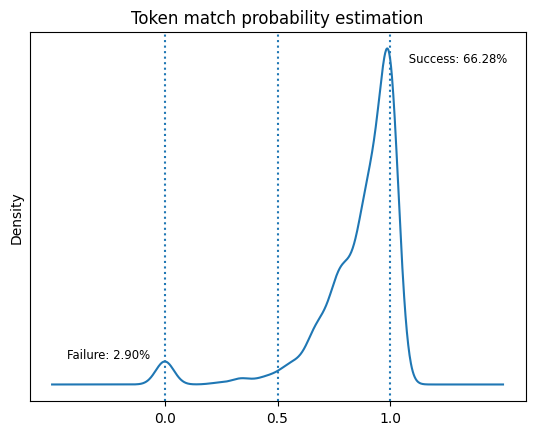

In [25]:
(tokens[tokens['index']!=-1]['proba']).plot(kind='density')
for x in [0, 0.5, 1]:
    plt.axvline(x=x, linestyle=':')
    
graph = plt.gca().lines[0]
X = graph.get_xdata()
Y = graph.get_ydata()

v = len(tokens[tokens['proba'] == 0])/len(tokens)
plt.text(0, Y[np.argwhere(X >= 0)[0][0]], f'Failure: {v:.2%}    ',
         verticalalignment='bottom', horizontalalignment='right', fontsize='small')

v = len(tokens[tokens['proba'] >= stats.loc['mean']])/len(tokens)
plt.text(1, Y[np.argwhere(X >= 1)[0][0]], f'     Success: {v:.2%}',
         horizontalalignment='left', fontsize='small')

plt.xticks([0, 0.5, 1])
plt.yticks([])
plt.title('Token match probability estimation')
plt.show()

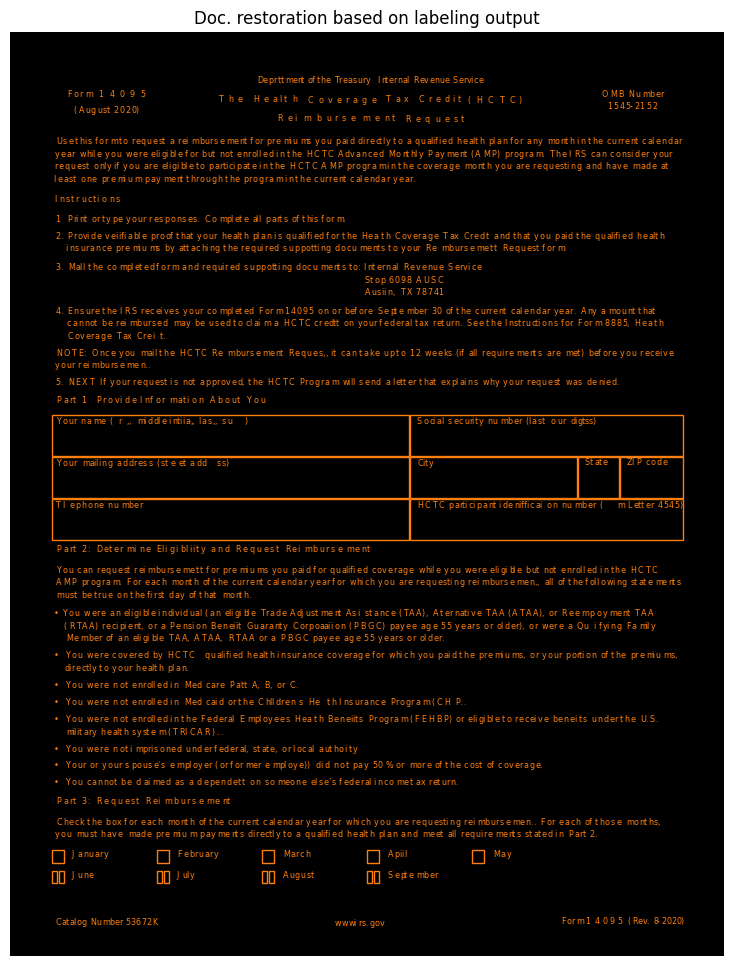

In [26]:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(np.zeros(image.shape), 'gray')
    for x, y, w, h, t, label, p in tokens.loc[tokens['proba'] > 0, BOX + ['type','label','proba']].values:
        if t == INPUT:
            ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='C1', facecolor='none'))
        else:
            ax.text(x + w//2, y + h//2, label, color='C1', fontsize='xx-small')
    ax.set_title('Doc. restoration based on labeling output')
    plt.axis('off')
    plt.show()

In [27]:
    def get_block_text(tokens, bi):
        chars = tokens[(tokens['block-index']==bi)&(tokens['type']==CHAR)]
        # aggregate words
        text = chars.groupby(['line-index','word-index']).sum()['label']
        # aggregate lines
        text = text.apply(lambda x:f'{x} ').groupby(['line-index']).sum()
        # aggregate block
        return text.apply(lambda x:f'{x}\n').sum()

    bi = np.random.choice(boxes[boxes['type'].isin([CELL, BLOCK])].index)
    print(f'--- {bi} ----------------------------------------------------------------------------------------')
    print(get_block_text(tokens, bi))

--- 20 ----------------------------------------------------------------------------------------
Catalog Number 53672K 



In [28]:
# inputs
tokens[tokens['type']==INPUT].groupby('label').size()

label
CheckBox    35
ComboBox     3
Text        41
dtype: int64

In [29]:
matched = tokens[tokens['type']==INPUT].groupby(['index','label']).size()
print(f"Inputs: {len(matched)} of {len(inputs if inputs is not None else [])} matched")
matched

Inputs: 17 of 17 matched


index  label   
3069   Text        23
3070   Text         3
3071   Text         1
3072   Text         6
3073   ComboBox     3
3074   Text         1
3075   Text         6
3076   Text         1
3077   CheckBox     1
3078   CheckBox     1
3079   CheckBox     1
3080   CheckBox     5
3081   CheckBox     2
3082   CheckBox     6
3083   CheckBox     5
3084   CheckBox     5
3085   CheckBox     9
dtype: int64

In [30]:
round(len(tokens[(tokens['proba'] > 0.7)&(tokens['type']==CHAR)])/len(tokens[tokens['type']==CHAR]), 2)

0.88